In [ ]:
# ===============================
# Deep Neural Network using PyTorch made faster
# Dataset: Cat and Dogs Recognition
# ===============================
import os
from math import *
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import List, Optional, Tuple
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from functools import partial
import optuna

In [ ]:
def load_data(
    validation_ratio: float = 0.5,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load training and test data from HDF5 files and split test set into validation and final test sets

    Parameters
    validation_ratio : float, optional (default=0.5)
        Fraction of the original test set to use as validation data
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    X_test : np.ndarray
        Test features
    y_test : np.ndarray
        Test labels
    """
    # Load training data
    with h5py.File("../cat_dog_datasets/trainset.hdf5", "r") as train_dataset:
        X_train = np.array(train_dataset["X_train"][:])
        y_train = np.array(train_dataset["Y_train"][:])

    # Load test data
    with h5py.File("../cat_dog_datasets/testset.hdf5", "r") as test_dataset:
        X_test_full = np.array(test_dataset["X_test"][:])
        y_test_full = np.array(test_dataset["Y_test"][:])

    # Split test data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_full,
        y_test_full,
        test_size=validation_ratio,
        random_state=random_state,
        stratify=y_test_full if len(np.unique(y_test_full)) > 1 else None
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
# Define human-readable label names
label_names = {0: "Cat", 1: "Dog"}

def plot_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int] = (64, 64)
):
    """
    Plot flattened/normalized images with true and predicted labels
    
    Parameters:
    X : np.ndarray
        Flattened images (N, features)
    y : np.ndarray
        One-hot encoded true labels (N, num_classes)
    y_pred : np.ndarray, optional
        One-hot encoded predicted labels (N, num_classes)
    img_shape : tuple
        Original image shape (H, W)

    Returns:
    """
    # Convert one-hot to integer labels if needed
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y

    # Dynamically compute grid size
    n_cols = min(5, num_images)  # max 5 images per row
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(4*n_cols, 4*n_rows))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Reshape flattened image back to original shape
        img = X[i].reshape(img_shape)
        plt.imshow(img, cmap='gray')
        
        # Title with True / Pred labels
        title = f"True: {label_names[y_int[i]]}"
        if y_pred is not None:
            title += f"\nPred: {label_names[y_pred[i]]}"
            
            # Optional: color title green/red for correct/incorrect
            color = 'green' if y_int[i] == y_pred[i] else 'red'
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

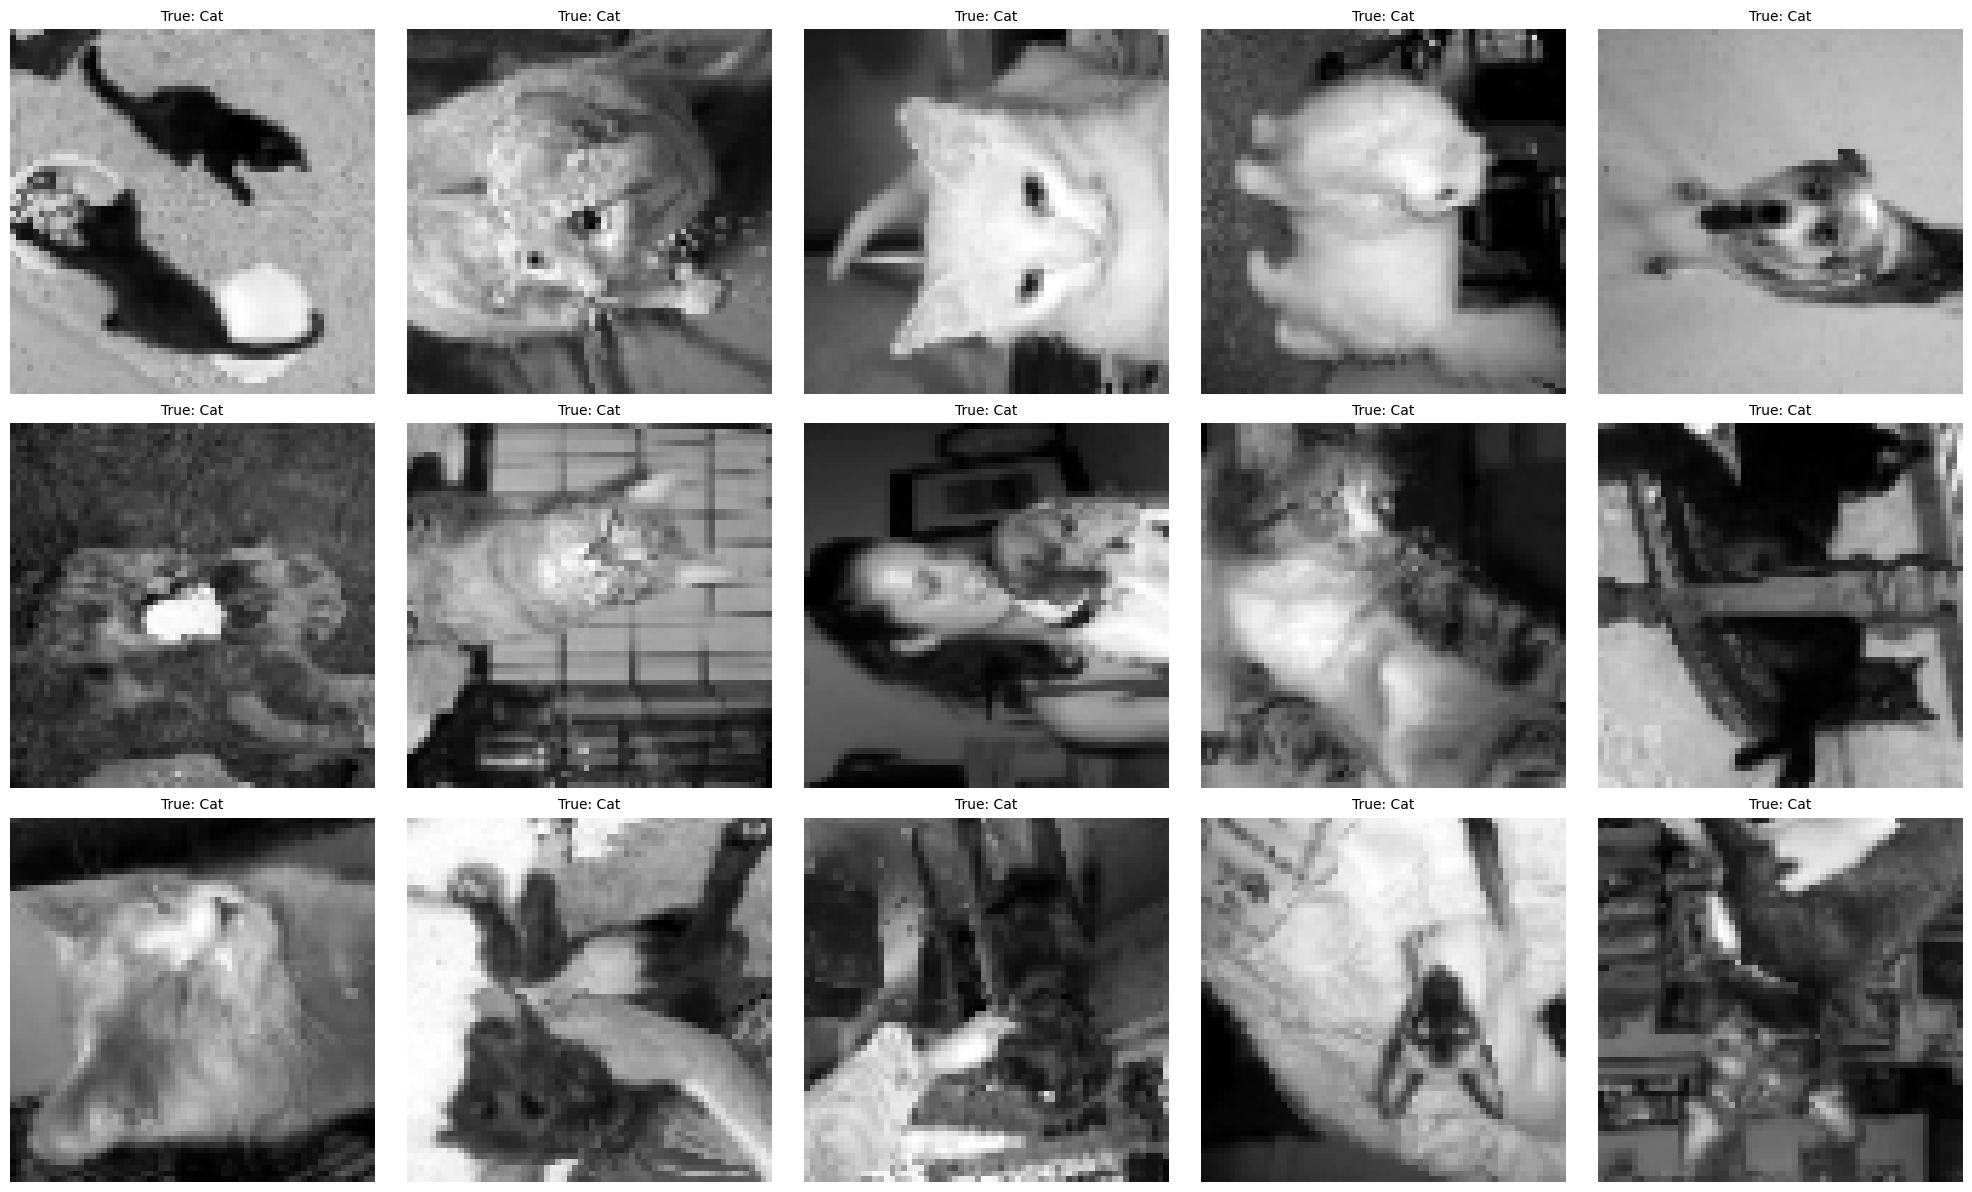

Preprocessing data...


c:\SafApp\Python\Python3.12-64\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\SafApp\Python\Python3.12-64\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\SafApp\Python\Python3.12-64\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# =======================================
# 1. Load and Preprocess Data
# =======================================
X_train, y_train, X_val, y_val, X_test, y_test = load_data()
img_shape = X_train.shape[1:]

# Data Augmentation Function
def augment_image(
    image: tf.Tensor
) -> tf.Tensor:
    """
    Apply data augmentation to a single image tensor
    
    Parameters:
    image : tf.Tensor
        Input image tensor

    Returns:
    tf.Tensor
        Augmented image tensor
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Small rotations
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random brightness / contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Small zoom (crop + resize)
    crop_scale = tf.random.uniform([], 0.9, 1.0)
    crop_size = tf.cast(crop_scale * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=tf.concat([crop_size, tf.shape(image)[-1:]], axis=0))
    image = tf.image.resize(image, img_shape[:2])
    
    return image

# Apply augmentation to the whole dataset
X_train_aug = []
for i in range(X_train.shape[0]):
    img = tf.convert_to_tensor(X_train[i], dtype=tf.float32)
    if len(img.shape) == 2:  # Add channel dimension if missing
        img = tf.expand_dims(img, axis=-1)
    img_aug = augment_image(img)
    X_train_aug.append(img_aug.numpy())

X_train = np.array(X_train_aug)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
plot_images(X_train, y_train, num_images=15)

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))

[I 2025-10-30 14:51:42,251] A new study created in memory with name: no-name-07887f0e-45bc-40d3-8b6e-32c4f06f498d


Using device: cpu
Epoch [5/40] | Train Loss: 0.6621 - Val Loss: 0.7476
Epoch [10/40] | Train Loss: 0.5080 - Val Loss: 1.1029


[I 2025-10-30 14:53:27,994] Trial 0 finished with value: 1.5175279331207276 and parameters: {'n_layers': 3, 'n_units_l0': 459, 'n_units_l1': 180, 'n_units_l2': 143, 'activation': 'tanh', 'dropout_l0': 0.16271759205474373, 'dropout_l1': 0.29701989792769345, 'dropout_l2': 0.3063962846737984, 'weight_decay': 1.221115955363888e-06, 'lr': 0.000685464284872236, 'batch_size': 32, 'step_size': 14.677130587679555, 'gamma': 0.7866004065815516, 'stopping_patience': 12}. Best is trial 0 with value: 1.5175279331207276.


Epoch [15/40] | Train Loss: 0.3323 - Val Loss: 1.5175
Early stopping triggered.
Epoch [5/40] | Train Loss: 0.7085 - Val Loss: 0.7160
Epoch [10/40] | Train Loss: 0.6556 - Val Loss: 0.7663


[I 2025-10-30 14:53:48,674] Trial 1 finished with value: 0.7801460027694702 and parameters: {'n_layers': 4, 'n_units_l0': 199, 'n_units_l1': 503, 'n_units_l2': 226, 'n_units_l3': 73, 'activation': 'tanh', 'dropout_l0': 0.3652214581090665, 'dropout_l1': 0.22012248581885369, 'dropout_l2': 0.22173382171971068, 'dropout_l3': 0.2650206882739612, 'weight_decay': 0.0009134244252320593, 'lr': 0.00018295034061674756, 'batch_size': 128, 'step_size': 6.161356742297659, 'gamma': 0.7831479216438232, 'stopping_patience': 9}. Best is trial 1 with value: 0.7801460027694702.


Early stopping triggered.
Epoch [5/40] | Train Loss: 0.6972 - Val Loss: 0.7796
Epoch [10/40] | Train Loss: 0.5498 - Val Loss: 0.9113


[I 2025-10-30 14:54:12,093] Trial 2 finished with value: 1.1294845294952394 and parameters: {'n_layers': 4, 'n_units_l0': 324, 'n_units_l1': 260, 'n_units_l2': 66, 'n_units_l3': 114, 'activation': 'relu', 'dropout_l0': 0.1974151750071111, 'dropout_l1': 0.3567320357896838, 'dropout_l2': 0.19567678867008403, 'dropout_l3': 0.2903791380381, 'weight_decay': 0.00010311097316881499, 'lr': 0.0018273347023827094, 'batch_size': 64, 'step_size': 12.907392686291285, 'gamma': 0.8810554009559854, 'stopping_patience': 10}. Best is trial 1 with value: 0.7801460027694702.


Early stopping triggered.


W1030 14:54:30.359000 22924 site-packages\torch\_dynamo\convert_frame.py:1016] [5/8] torch._dynamo hit config.recompile_limit (8)
W1030 14:54:30.359000 22924 site-packages\torch\_dynamo\convert_frame.py:1016] [5/8]    function: 'forward' (C:\Users\sd351753\AppData\Local\Temp\ipykernel_22924\383262132.py:139)
W1030 14:54:30.359000 22924 site-packages\torch\_dynamo\convert_frame.py:1016] [5/8]    last reason: 5/7: GLOBAL_STATE changed: grad_mode 
W1030 14:54:30.359000 22924 site-packages\torch\_dynamo\convert_frame.py:1016] [5/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1030 14:54:30.359000 22924 site-packages\torch\_dynamo\convert_frame.py:1016] [5/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Epoch [5/40] | Train Loss: 0.5764 - Val Loss: 0.8417
Epoch [10/40] | Train Loss: 0.3590 - Val Loss: 1.0796
Epoch [15/40] | Train Loss: 0.2353 - Val Loss: 1.4572
Early stopping triggered.


[I 2025-10-30 14:54:34,910] Trial 3 finished with value: 1.6188241243362427 and parameters: {'n_layers': 2, 'n_units_l0': 108, 'n_units_l1': 381, 'activation': 'leaky_relu', 'dropout_l0': 0.2000685100174706, 'dropout_l1': 0.1679597815981671, 'weight_decay': 0.00011265042978167414, 'lr': 0.0013117252440493787, 'batch_size': 128, 'step_size': 15.13696523192102, 'gamma': 0.8662719805227564, 'stopping_patience': 15}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.6638 - Val Loss: 0.7429
Epoch [10/40] | Train Loss: 0.6073 - Val Loss: 0.7348
Epoch [15/40] | Train Loss: 0.5574 - Val Loss: 0.8173
Early stopping triggered.


[I 2025-10-30 14:55:02,380] Trial 4 finished with value: 0.8303704977035522 and parameters: {'n_layers': 4, 'n_units_l0': 214, 'n_units_l1': 372, 'n_units_l2': 188, 'n_units_l3': 120, 'activation': 'relu', 'dropout_l0': 0.2475395884363582, 'dropout_l1': 0.2887262537610855, 'dropout_l2': 0.2441207444990465, 'dropout_l3': 0.12315658277333726, 'weight_decay': 1.0654053234809255e-06, 'lr': 0.00018030270879640397, 'batch_size': 32, 'step_size': 11.097625691221502, 'gamma': 0.9593499148639636, 'stopping_patience': 14}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.4839 - Val Loss: 1.1467
Epoch [10/40] | Train Loss: 0.2783 - Val Loss: 1.7266
Epoch [15/40] | Train Loss: 0.1402 - Val Loss: 2.1322
Early stopping triggered.


[I 2025-10-30 14:55:29,885] Trial 5 finished with value: 2.400261468887329 and parameters: {'n_layers': 2, 'n_units_l0': 381, 'n_units_l1': 400, 'activation': 'leaky_relu', 'dropout_l0': 0.10088633468096662, 'dropout_l1': 0.16106269059162545, 'weight_decay': 1.1001967885398135e-06, 'lr': 0.0037326971566396597, 'batch_size': 64, 'step_size': 19.816363451517923, 'gamma': 0.9624851266476613, 'stopping_patience': 14}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.6334 - Val Loss: 0.8654
Epoch [10/40] | Train Loss: 0.4626 - Val Loss: 1.2077
Early stopping triggered.


[I 2025-10-30 14:55:58,242] Trial 6 finished with value: 1.29664530813694 and parameters: {'n_layers': 2, 'n_units_l0': 432, 'n_units_l1': 498, 'activation': 'relu', 'dropout_l0': 0.31722986158970345, 'dropout_l1': 0.2899136313446935, 'weight_decay': 1.4225970594750476e-06, 'lr': 0.0043433092092565895, 'batch_size': 32, 'step_size': 12.30298925114211, 'gamma': 0.9074901162923301, 'stopping_patience': 10}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.3799 - Val Loss: 0.9237
Epoch [10/40] | Train Loss: 0.2092 - Val Loss: 0.9904
Epoch [15/40] | Train Loss: 0.1322 - Val Loss: 1.1669
Early stopping triggered.


[I 2025-10-30 14:56:22,963] Trial 7 finished with value: 1.1668727397918701 and parameters: {'n_layers': 2, 'n_units_l0': 418, 'n_units_l1': 83, 'activation': 'leaky_relu', 'dropout_l0': 0.1275179219051169, 'dropout_l1': 0.19940630269636167, 'weight_decay': 8.286096689824283e-05, 'lr': 0.00020597080117718225, 'batch_size': 128, 'step_size': 5.440066436871352, 'gamma': 0.7641860761290239, 'stopping_patience': 12}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.5523 - Val Loss: 0.9467
Epoch [10/40] | Train Loss: 0.2595 - Val Loss: 1.1184
Epoch [15/40] | Train Loss: 0.1435 - Val Loss: 1.3974
Early stopping triggered.


[I 2025-10-30 14:56:46,598] Trial 8 finished with value: 1.6582839488983154 and parameters: {'n_layers': 2, 'n_units_l0': 481, 'n_units_l1': 95, 'activation': 'relu', 'dropout_l0': 0.13416907468426276, 'dropout_l1': 0.3934212032577179, 'weight_decay': 8.777899627949671e-05, 'lr': 0.0008576606344281404, 'batch_size': 128, 'step_size': 9.45877272366755, 'gamma': 0.7602810231380817, 'stopping_patience': 14}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.5043 - Val Loss: 1.1188
Epoch [10/40] | Train Loss: 0.3041 - Val Loss: 1.2833
Early stopping triggered.


[I 2025-10-30 14:57:11,667] Trial 9 finished with value: 1.8019630575180055 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 439, 'activation': 'relu', 'dropout_l0': 0.16995705976917042, 'dropout_l1': 0.33352076816010223, 'weight_decay': 0.00043651178505310845, 'lr': 0.0012354292485771724, 'batch_size': 64, 'step_size': 11.26542203803053, 'gamma': 0.7926477184944064, 'stopping_patience': 11}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.6801 - Val Loss: 0.7785
Epoch [10/40] | Train Loss: 0.5659 - Val Loss: 0.8310
Early stopping triggered.


[I 2025-10-30 14:57:33,414] Trial 10 finished with value: 0.8309709429740906 and parameters: {'n_layers': 3, 'n_units_l0': 219, 'n_units_l1': 290, 'n_units_l2': 255, 'activation': 'tanh', 'dropout_l0': 0.3792403620276601, 'dropout_l1': 0.11284534455331444, 'dropout_l2': 0.12109523408703471, 'weight_decay': 0.0008334003334808259, 'lr': 0.0001108441352304277, 'batch_size': 128, 'step_size': 5.033831494838152, 'gamma': 0.7005904907438055, 'stopping_patience': 6}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.6549 - Val Loss: 0.8491
Early stopping triggered.


[I 2025-10-30 14:59:48,379] Trial 11 finished with value: 0.930919418334961 and parameters: {'n_layers': 4, 'n_units_l0': 191, 'n_units_l1': 512, 'n_units_l2': 218, 'n_units_l3': 75, 'activation': 'tanh', 'dropout_l0': 0.2743561950435873, 'dropout_l1': 0.23953679737952585, 'dropout_l2': 0.2449299503643662, 'dropout_l3': 0.12607513192541292, 'weight_decay': 7.586156684759843e-06, 'lr': 0.00030911033724166436, 'batch_size': 32, 'step_size': 8.843707666227443, 'gamma': 0.9815149313176886, 'stopping_patience': 7}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.7369 - Val Loss: 0.7388
Epoch [10/40] | Train Loss: 0.6654 - Val Loss: 0.7965
Early stopping triggered.


[I 2025-10-30 15:00:24,659] Trial 12 finished with value: 0.8711342644691468 and parameters: {'n_layers': 4, 'n_units_l0': 227, 'n_units_l1': 323, 'n_units_l2': 182, 'n_units_l3': 127, 'activation': 'tanh', 'dropout_l0': 0.38910608889977794, 'dropout_l1': 0.24047689019699722, 'dropout_l2': 0.38461472516189404, 'dropout_l3': 0.1944795825304213, 'weight_decay': 9.183252767107226e-06, 'lr': 0.00031000024178392757, 'batch_size': 32, 'step_size': 7.500454621474395, 'gamma': 0.8380556356208527, 'stopping_patience': 9}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 1.0665 - Val Loss: 0.7686
Epoch [10/40] | Train Loss: 0.8030 - Val Loss: 0.7826
Epoch [15/40] | Train Loss: 0.7776 - Val Loss: 0.8400
Early stopping triggered.


[I 2025-10-30 15:00:51,076] Trial 13 finished with value: 0.7831810665130615 and parameters: {'n_layers': 4, 'n_units_l0': 106, 'n_units_l1': 444, 'n_units_l2': 191, 'n_units_l3': 64, 'activation': 'relu', 'dropout_l0': 0.26403026079214986, 'dropout_l1': 0.28229935988977856, 'dropout_l2': 0.20784807883836334, 'dropout_l3': 0.3838508452051514, 'weight_decay': 1.33481461157345e-05, 'lr': 0.00010348359894860845, 'batch_size': 32, 'step_size': 17.67718523294704, 'gamma': 0.7148254636143652, 'stopping_patience': 8}. Best is trial 1 with value: 0.7801460027694702.


Epoch [5/40] | Train Loss: 0.7077 - Val Loss: 0.7384
Early stopping triggered.


[I 2025-10-30 15:01:12,887] Trial 14 finished with value: 0.7599350810050964 and parameters: {'n_layers': 3, 'n_units_l0': 69, 'n_units_l1': 459, 'n_units_l2': 239, 'activation': 'tanh', 'dropout_l0': 0.3510281614748831, 'dropout_l1': 0.2136745742710951, 'dropout_l2': 0.16488477073238367, 'weight_decay': 1.1637387666101166e-05, 'lr': 0.00011386420588873124, 'batch_size': 128, 'step_size': 19.504718993238868, 'gamma': 0.7016797159570095, 'stopping_patience': 8}. Best is trial 14 with value: 0.7599350810050964.


Epoch [5/40] | Train Loss: 0.6969 - Val Loss: 0.8602
Early stopping triggered.


[I 2025-10-30 15:01:38,543] Trial 15 finished with value: 0.8505546450614929 and parameters: {'n_layers': 3, 'n_units_l0': 73, 'n_units_l1': 458, 'n_units_l2': 243, 'activation': 'tanh', 'dropout_l0': 0.3422855363408654, 'dropout_l1': 0.2002800846150985, 'dropout_l2': 0.12620467271924346, 'weight_decay': 2.2058359241232537e-05, 'lr': 0.00041688930274500613, 'batch_size': 128, 'step_size': 19.750089587228427, 'gamma': 0.7308158207263247, 'stopping_patience': 5}. Best is trial 14 with value: 0.7599350810050964.


Epoch [5/40] | Train Loss: 0.6417 - Val Loss: 0.7347
Epoch [10/40] | Train Loss: 0.5431 - Val Loss: 0.7692
Early stopping triggered.


[I 2025-10-30 15:02:05,414] Trial 16 finished with value: 0.7692083716392517 and parameters: {'n_layers': 3, 'n_units_l0': 154, 'n_units_l1': 209, 'n_units_l2': 132, 'activation': 'tanh', 'dropout_l0': 0.33278974063145983, 'dropout_l1': 0.10035541228887096, 'dropout_l2': 0.17087300195751742, 'weight_decay': 3.585566397377136e-06, 'lr': 0.0001768956625668152, 'batch_size': 128, 'step_size': 15.933430409808192, 'gamma': 0.8110654388006472, 'stopping_patience': 8}. Best is trial 14 with value: 0.7599350810050964.


Epoch [5/40] | Train Loss: 0.6380 - Val Loss: 0.7502
Early stopping triggered.


[I 2025-10-30 15:02:32,860] Trial 17 finished with value: 0.7644097208976746 and parameters: {'n_layers': 3, 'n_units_l0': 143, 'n_units_l1': 205, 'n_units_l2': 131, 'activation': 'tanh', 'dropout_l0': 0.30459062560472294, 'dropout_l1': 0.11092713309664023, 'dropout_l2': 0.16096323340115384, 'weight_decay': 4.010002130839038e-06, 'lr': 0.00014344046310828167, 'batch_size': 128, 'step_size': 17.347290279410885, 'gamma': 0.8224496813539377, 'stopping_patience': 7}. Best is trial 14 with value: 0.7599350810050964.


Epoch [5/40] | Train Loss: 0.6303 - Val Loss: 0.7530
Early stopping triggered.


[I 2025-10-30 15:03:04,409] Trial 18 finished with value: 0.7705925107002258 and parameters: {'n_layers': 3, 'n_units_l0': 293, 'n_units_l1': 177, 'n_units_l2': 101, 'activation': 'tanh', 'dropout_l0': 0.2973670460150225, 'dropout_l1': 0.13878384756438056, 'dropout_l2': 0.15856535526046564, 'weight_decay': 3.856926585639949e-06, 'lr': 0.0001044005089787199, 'batch_size': 128, 'step_size': 17.80506658805354, 'gamma': 0.734629282962917, 'stopping_patience': 5}. Best is trial 14 with value: 0.7599350810050964.


Epoch [5/40] | Train Loss: 0.6509 - Val Loss: 0.7657
Early stopping triggered.


[I 2025-10-30 15:03:33,370] Trial 19 finished with value: 0.7850766777992249 and parameters: {'n_layers': 3, 'n_units_l0': 134, 'n_units_l1': 129, 'n_units_l2': 102, 'activation': 'tanh', 'dropout_l0': 0.23474802537733494, 'dropout_l1': 0.1409747986166734, 'dropout_l2': 0.29176272675994835, 'weight_decay': 3.6003244449863625e-05, 'lr': 0.00042516533345014664, 'batch_size': 128, 'step_size': 17.853063985306747, 'gamma': 0.9174964736343196, 'stopping_patience': 7}. Best is trial 14 with value: 0.7599350810050964.


Best trial:
  Value: 0.7599
  Params:
    n_layers: 3
    n_units_l0: 69
    n_units_l1: 459
    n_units_l2: 239
    activation: tanh
    dropout_l0: 0.3510281614748831
    dropout_l1: 0.2136745742710951
    dropout_l2: 0.16488477073238367
    weight_decay: 1.1637387666101166e-05
    lr: 0.00011386420588873124
    batch_size: 128
    step_size: 19.504718993238868
    gamma: 0.7016797159570095
    stopping_patience: 8
Epoch [5/40] | Train Loss: 0.7068 - Val Loss: 0.7586
Epoch [10/40] | Train Loss: 0.6534 - Val Loss: 0.8024
Early stopping triggered.


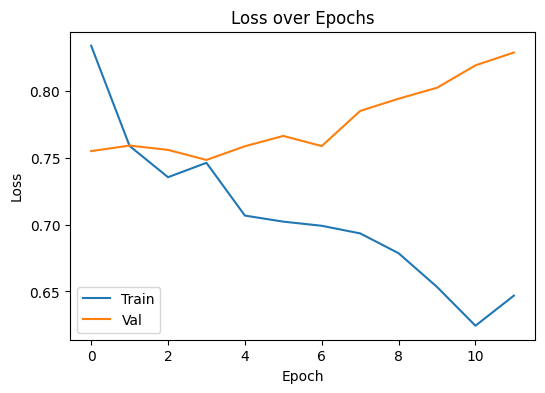

Test Accuracy: 51.00%


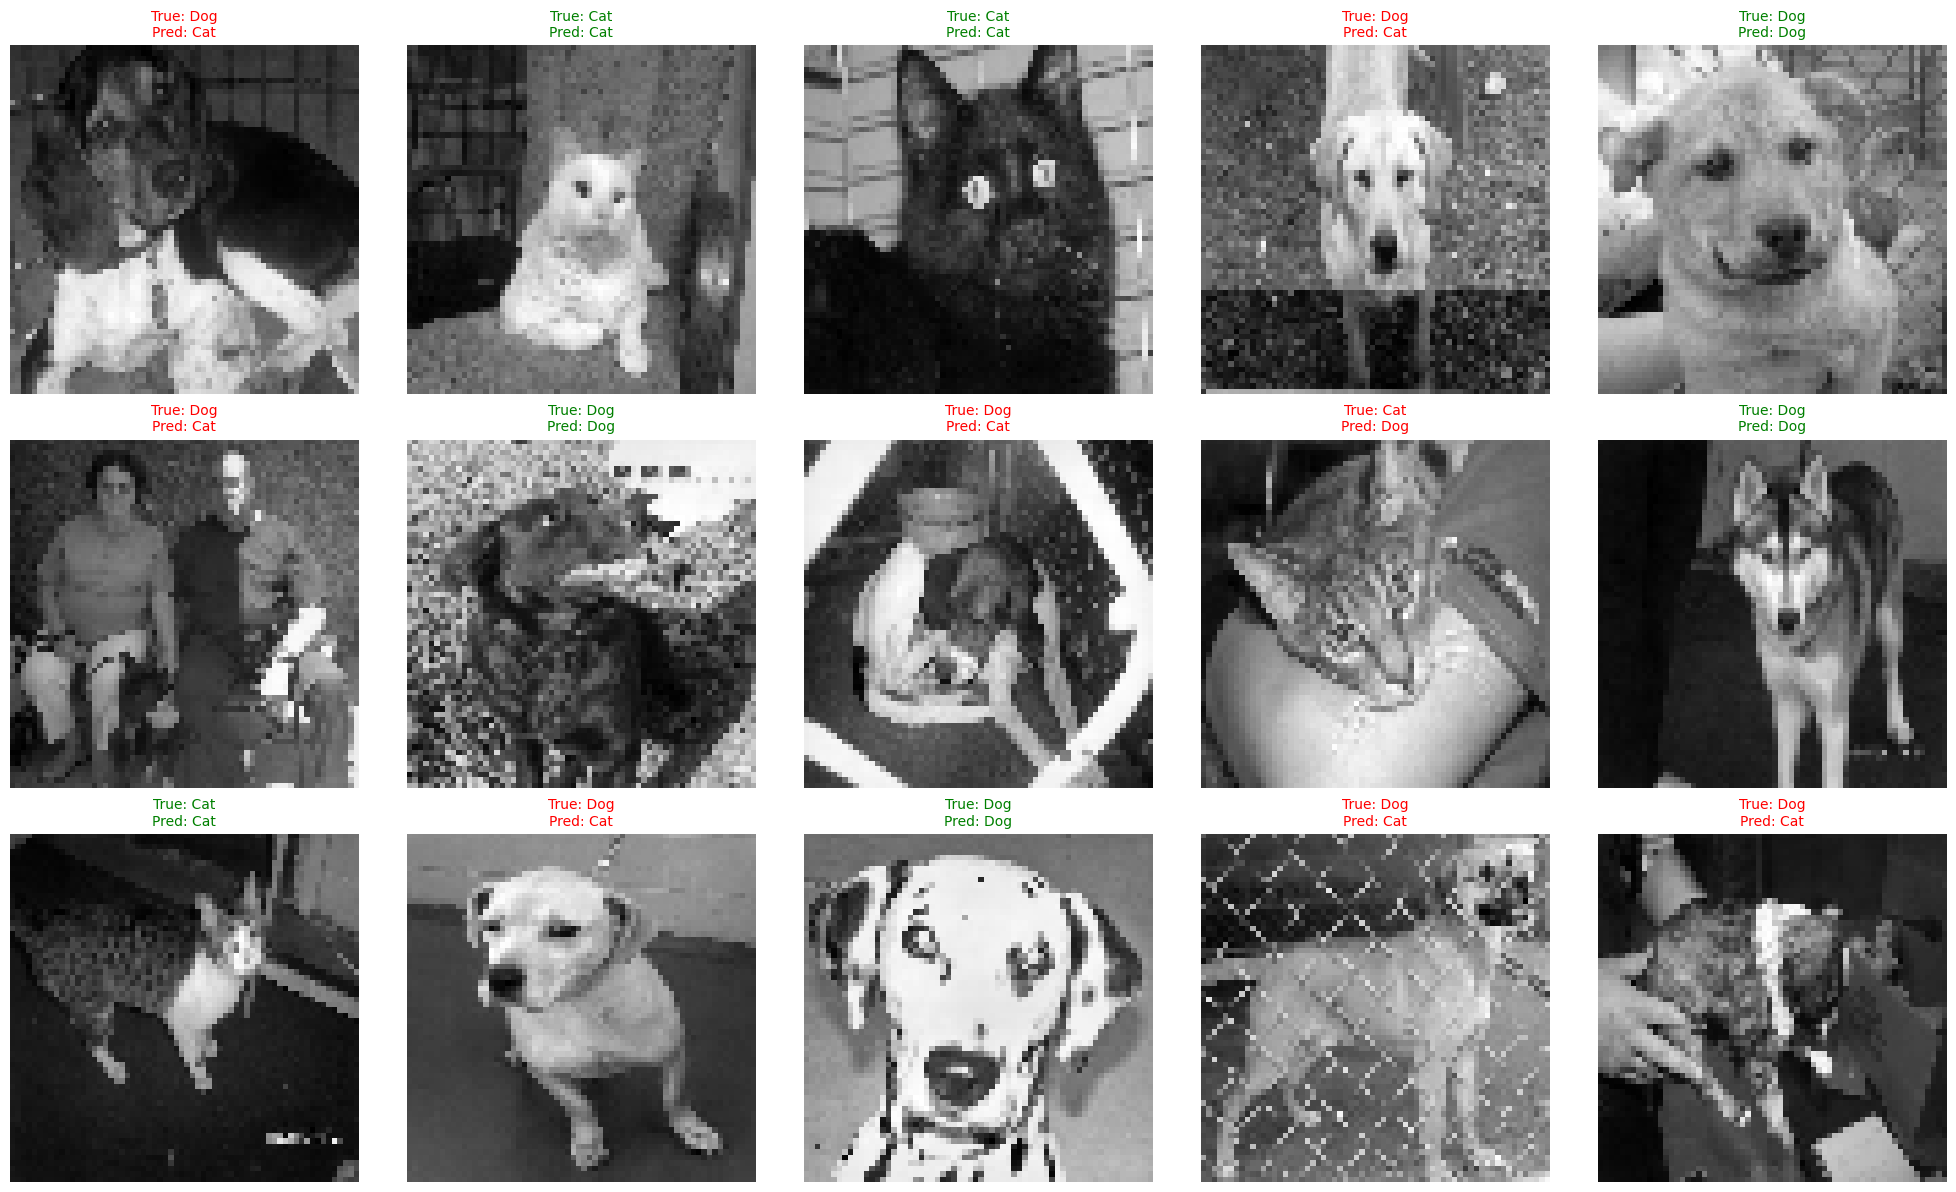

In [ ]:
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.fastest = True
    torch.set_float32_matmul_precision('high')
else:
    torch.set_num_threads(os.cpu_count())

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(RNG_SEED)

#  Mixed Precision & Dataloader Settings
USE_AMP = torch.cuda.is_available()   # enable AMP only if GPU is available
PIN_MEMORY = torch.cuda.is_available()  # pin_memory only makes sense on GPU


# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tensor_dataset(
    X: np.ndarray,
    y: np.ndarray
) -> TensorDataset:
    """
    Convert numpy arrays to PyTorch TensorDataset
    
    Parameters:
    X : np.ndarray
        Feature array
    y : np.ndarray
        Label array
        
    Returns:
    TensorDataset
        PyTorch TensorDataset
    """
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X_tensor, y_tensor)

def make_dataloaders(
    dataset: TensorDataset,
    batch_size: int,
    shuffle: bool = False
) -> DataLoader:
    """
    Create DataLoader from TensorDataset

    Parameters:
    dataset : TensorDataset
        Input TensorDataset
    batch_size : int
        Batch size for DataLoader
    shuffle : bool, optional
        Whether to shuffle the data
    Returns:
    DataLoader
        PyTorch DataLoader
    """
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                      num_workers=os.cpu_count(), 
                      pin_memory=PIN_MEMORY, 
                      persistent_workers=True if os.cpu_count() > 1 else False
                    )

# Datasets
train_dataset = df_to_tensor_dataset(X_train, y_train)
val_dataset = df_to_tensor_dataset(X_val, y_val)
test_dataset = df_to_tensor_dataset(X_test, y_test)


# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
    "gelu": nn.GELU,
    "elu": nn.ELU,
    "softmax_logit": None  # handled as logits for CrossEntropy
}


# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    momentum: float = 0.9
    optimizer_type: str = "adam"
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = USE_AMP


# =======================================
# 5. Model Definition
# =======================================
class DeepNN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True
    ):
        """
        Deep Neural Network with configurable architecture

        Parameters:
        input_dim : int
            Dimension of input features
        hidden_layers : List[int]
            List containing the number of units in each hidden layer
        output_dim : int
            Number of output classes
        activations : List[str], optional
            List of activation function names for each hidden layer
        dropout_rates : List[float], optional
            List of dropout rates for each hidden layer
        use_batchnorm : bool, optional
            Whether to use batch normalization after each hidden layer

        Returns:
        """
        super().__init__()
        layers = []
        prev = input_dim
        n_hidden = len(hidden_layers)

        if activations is None:
            activations = ["relu"] * n_hidden
        if dropout_rates is None:
            dropout_rates = [0.0] * n_hidden
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        for idx, h in enumerate(hidden_layers):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            if act_ctor is None and act_name != "softmax_logit":
                raise ValueError(f"Unsupported activation: {act_name}")
            if act_ctor is not None:
                layers.append(act_ctor())
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                layers.append(nn.Dropout(dropout_rates[idx]))
            prev = h
        
        # Output layer (no activation here if using CrossEntropy)
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

        self._init_weights(activations)

    def _init_weights(
        self,
        activations: List[str]
    ):
        """
        Initialize weights of the network based on activation functions

        Parameters:
        activations : List[str]
            List of activation function names for each hidden layer

        Returns:
        """
        idx_hidden = 0
        for m in self.net:
            if isinstance(m, nn.Linear):
                # choose activation of the incoming layer index
                act = activations[idx_hidden] if idx_hidden < len(activations) else None
                if act in ("relu", "leaky_relu"):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu") # He init
                else:
                    nn.init.xavier_normal_(m.weight) # Xavier init
                nn.init.zeros_(m.bias)
                idx_hidden += 1

    def forward(
        self, 
        x: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass through the network
        
        Parameters:
        x : torch.Tensor
            Input tensor
        Returns:
        torch.Tensor
            Output tensor
        """
        return self.net(x)
    

# =======================================
# 6. Training Loop
# =======================================
def train_model(
    train_dataset: TensorDataset,
    val_dataset: TensorDataset,
    input_dim: int, 
    output_dim: int,
    config: TrainConfig,
    print_every=10, plot_loss=False
) -> nn.Module:
    """
    Train the Deep Neural Network model

    Parameters:
    train_dataset : TensorDataset
        Training dataset
    val_dataset : TensorDataset
        Validation dataset
    input_dim : int
        Input feature dimension
    output_dim : int
        Number of output classes
    config : TrainConfig
        Training configuration
    print_every : int, optional
        Frequency of printing training progress
    plot_loss : bool, optional
        Whether to plot loss curves after training

    Returns:
    nn.Module
        Trained PyTorch model
    """
    # Data preparation
    train_loader = make_dataloaders(train_dataset, config.batch_size, shuffle=True)
    val_loader = make_dataloaders(val_dataset, config.batch_size, shuffle=False)

    # Model creation
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.fastest = True
    model = DeepNN(input_dim, config.hidden_layers, output_dim, config.activations, config.dropout_rates)
    model.to(device)
    model = torch.compile(model) # if no C++ available add: , backend="aot_eager")

    optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    criterion = nn.CrossEntropyLoss() if config.loss_function == "cross_entropy" else nn.MSELoss()
    scaler = torch.amp.GradScaler(enabled=config.use_amp)

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(config.epochs):
        # Training
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device.type, enabled=config.use_amp):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            scaler.scale(loss).backward()
            if config.clip_grad_norm:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * X_batch.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch = X_val_batch.to(device, non_blocking=True)
                y_val_batch = y_val_batch.to(device, non_blocking=True)
                with torch.amp.autocast(device_type=device.type, enabled=config.use_amp):
                    outputs_val = model(X_val_batch)
                    loss_val = criterion(outputs_val, y_val_batch)
                val_loss += loss_val.item() * X_val_batch.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

         # Early stopping
        if config.early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print("Early stopping triggered.")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    if plot_loss:
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Val")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model


# =======================================
# 7. Prediction & Evaluation
# =======================================
# Prediction function for any DataLoader
def predict_loader(
    model: nn.Module,
    loader: DataLoader,
    device: Optional[torch.device] = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Predict classes and probabilities for data in DataLoader

    Parameters:
    model : nn.Module
        Trained PyTorch model
    loader : DataLoader
        DataLoader for input data
    device : torch.device, optional
        Device to run the model on

    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        Predicted classes, predicted probabilities, true labels
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    
    all_probs, all_preds, all_targets = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    return (
        torch.cat(all_preds).numpy(),
        torch.cat(all_probs).numpy(),
        torch.cat(all_targets).numpy(),
    )

def accuracy_score(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> float:
    """
    Compute accuracy score between true and predicted labels

    Parameters:
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predicted labels
        
    Returns:
    float
        Accuracy percentage
    """
    return np.mean(y_true == y_pred) * 100


# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(
    trial: optuna.trial.Trial,
    loss_function: str = "cross_entropy",
    epochs: int = 40
) -> float:
    """
    Objective function for Optuna hyperparameter optimization

    Parameters:
    trial : optuna.trial.Trial
        Optuna trial object
    loss_function : str, optional
        Loss function to use
    epochs : int, optional
        Number of training epochs
    Returns:
    float
        Validation loss to minimize
    """
    # Number of hidden layers (shallower works better on raw pixels)
    n_layers = trial.suggest_int("n_layers", 2, 4) 

    # Decreasing width pattern (funnel architecture)
    hidden_layers = []
    for i in range(n_layers):
        max_units = max(64, input_dim // (2 ** (i + 2)))
        hidden_layers.append(trial.suggest_int(f"n_units_l{i}", 64, min(max_units, 512)))
        
    # Common activation (keeps optimization stable)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])
    activations = [activation] * n_layers
    # possible_activations = ["relu", "tanh", "leaky_relu"]
    # activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_layers)]

    # Regularization
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.1, 0.4) for i in range(n_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Optimizer params
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    step_size = trial.suggest_float("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.7, 0.99, log=True)

    # Early stopping
    stopping_patience = trial.suggest_int("stopping_patience", 5, 15)

    config = TrainConfig(
        hidden_layers=hidden_layers, 
        activations=activations, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=USE_AMP
    )

    model = train_model(
        train_dataset, val_dataset,
        input_dim, output_dim,
        config,
        print_every=5, plot_loss=False
    )

    # Validation loss
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    model.eval()
    criterion = nn.CrossEntropyLoss() if loss_function == "cross_entropy" else nn.MSELoss()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val_batch in val_loader:
            x_val, y_val_batch = x_val.to(device), y_val_batch.to(device)
            logits = model(x_val)
            val_loss += criterion(logits, y_val_batch).item() * x_val.size(0)
    val_loss /= len(val_loader.dataset)
    return val_loss

# Run Optuna study
loss_function = "cross_entropy"
epochs = 40
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=20)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_layers = best_params["n_layers"]
hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_layers)]
weight_decay = best_params["weight_decay"]
stopping_patience = best_params["stopping_patience"]
# activations = [best_params[f"activation_l{i}"] for i in range(n_layers)]
activations = [best_params["activation"]] * n_layers
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    hidden_layers=hidden_layers, 
    activations=activations, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs, 
    weight_decay=weight_decay, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=USE_AMP
    )

# Retrain final model
best_model = train_model(
    train_dataset, val_dataset,
    input_dim, output_dim,
    config,
    print_every=5, plot_loss=True
)

# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)
y_pred_test, _, _ = predict_loader(best_model, test_loader, device)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=15)